In [ ]:
#%% Mount Google drive if you use colab for save and load files
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# from gekko import GEKKO
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump
from sklearn.preprocessing import MinMaxScaler
import time

# For LSTM model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tqdm.keras import TqdmCallback

In [ ]:
data = pd.read_pickle(path + 'open_loop_data_SISO.pkl')

In [ ]:
data["y"][1:] = data["y"][0:-1] 

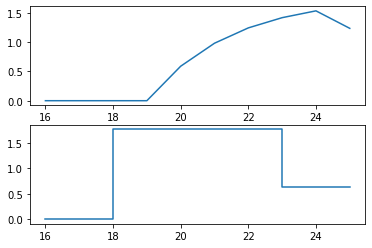

In [ ]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(data["y"][15:25])
plt.subplot(2,1,2)
plt.plot(data["u"][15:25], drawstyle='steps')
plt.show()

## 4. Train LSTM Network

In [ ]:
window = 5
P = 10

# Scale features
s1 = MinMaxScaler(feature_range=(-1,1))
Xs = s1.fit_transform(data[['u','y']])
s2 = MinMaxScaler(feature_range=(-1,1))
Ys = s2.fit_transform(data[['y']])

In [ ]:
Ys.shape, Xs.shape

((1600, 1), (1600, 2))

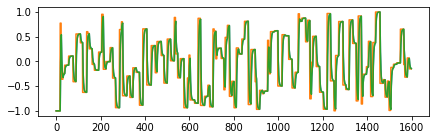

In [ ]:
plt.figure(figsize=[7,2])
plt.plot(Ys)
plt.plot(Xs)

In [ ]:
# Save model parameters
model_params = dict()
model_params['Xscale'] = s1
model_params['yscale'] = s2
model_params['window'] = window
model_params['P'] = P # prediction horizon

dump(model_params, open(path + 'model_param.pkl', 'wb'))


In [ ]:
nstep = Xs.shape[0]
val_ratio = 0.5
cut_index = np.int(nstep*val_ratio) # index number to separate the training and validation set
print(cut_index)
Xs_train = Xs[0:cut_index]
Ys_train = Ys[0:cut_index]
Xs_val = Xs[cut_index:]
Ys_val = Ys[cut_index:]

800


## Preparing training data for simultaneous **multi-step** prediction
X_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:(\text{window + P})\: \times\: \text{Nvariables}}$  
Y_train $\in$ $\mathbb{R}$ $^{\text{Batch}\: \times \:\text{P}\: \times\: \text{Nvariables}}$  


In [ ]:
X_train = []
Y_train = []
for i in range(window,len(Xs_train)-P):
    X_train.append(Xs_train[i-window:i+P,:])
    Y_train.append(Ys_train[i:i+P])

X_val = []
Y_val = []
for i in range(window,len(Xs_val)-P):
    X_val.append(Xs_val[i-window:i+P,:])
    Y_val.append(Ys_val[i:i+P])

In [ ]:
# Reshape data to format accepted by LSTM
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_val, Y_val = np.array(X_val), np.array(Y_val)

## Replacing outputs in the prediction horizon ($\text y_{k+i}$) with the latest measured value ($\text y_k$)  , where, $i = 1, 2, ... ,\text P$

In [ ]:
for i in range(0, len(X_train)):
  X_train[i][window:,1] = X_train[i][window-1,1]

for i in range(0, len(X_val)):
  X_val[i][window:,1] = X_val[i][window-1,1]

In [ ]:
# Demension of training data set
Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1]))
np.shape(X_train), np.shape(Y_train)

((785, 15, 2), (785, 10))

In [ ]:
X_train[15], Y_train[15]

(array([[-1.        , -1.        ],
        [-1.        , -1.        ],
        [-1.        , -1.        ],
        [ 0.77498176, -1.        ],
        [ 0.77498176, -0.40828378],
        [ 0.77498176, -0.40828378],
        [ 0.77498176, -0.40828378],
        [ 0.77498176, -0.40828378],
        [-0.35914504, -0.40828378],
        [-0.35914504, -0.40828378],
        [-0.35914504, -0.40828378],
        [-0.35914504, -0.40828378],
        [-0.35914504, -0.40828378],
        [-0.35914504, -0.40828378],
        [-0.35914504, -0.40828378]]),
 array([-0.0138063 ,  0.24917868,  0.42450201,  0.54138422,  0.24122789,
         0.04112366, -0.09227915, -0.18121436, -0.2405045 , -0.28003126]))

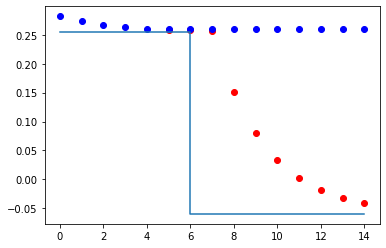

In [ ]:
i = 155
t = np.linspace(0, 14, 15)
plt.plot(t[5:],Y_train[i],'ro')
plt.plot(t, X_train[i][:,1],'bo')
plt.step(t, X_train[i][:,0])

In [ ]:
Y_train[160]

array([ 0.03416413,  0.00293141, -0.0178904 , -0.03177161, -0.04102575,
       -0.04719517, -0.05130813, -0.05405009, -0.09546113, -0.12306849])

In [ ]:
X_train[160]

array([[ 0.25500785,  0.25866154],
       [ 0.25500785,  0.25748298],
       [-0.05962245,  0.25669727],
       [-0.05962245,  0.15128684],
       [-0.05962245,  0.08101322],
       [-0.05962245,  0.08101322],
       [-0.05962245,  0.08101322],
       [-0.05962245,  0.08101322],
       [-0.05962245,  0.08101322],
       [-0.05962245,  0.08101322],
       [-0.05962245,  0.08101322],
       [-0.05962245,  0.08101322],
       [-0.17836046,  0.08101322],
       [-0.17836046,  0.08101322],
       [-0.17836046,  0.08101322]])

In [ ]:
# # Initialize LSTM model
model_lstm = Sequential()

model_lstm.add(LSTM(units=100, return_sequences=True, \
          input_shape=(X_train.shape[1],X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100, return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=100))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=Y_train.shape[1])) #units = number of outputs
model_lstm.compile(optimizer = 'adam', loss = 'mean_squared_error',\
              metrics = ['accuracy'])
# Allow for early exit
es_lstm = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

(785, 15, 2)

In [ ]:
# Fit (and time) LSTM model
t0 = time.time()
result_lstm = model_lstm.fit(X_train, Y_train, epochs = 300, batch_size = 32,\
                             callbacks=[es_lstm, TqdmCallback(verbose=1)],\
                             verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

model_lstm.summary()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00021: early stopping
Runtime: 8.32 s
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15, 100)           41200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 15, 100)           80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (D

In [ ]:
#%% Save LSTM model file
# model_lstm.save(path + 'MPC_surrogate_SISO_FOPDT_multistep_LSTM.h5')

## 2. Transformer

In [ ]:
n_feature = X_train.shape[2]
n_label = Y_train.shape[1]

encoder_input = tf.keras.layers.Input(shape=(window+P, n_feature))
xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(encoder_input,encoder_input)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)

xl = tf.keras.layers.MultiHeadAttention(num_heads=10,key_dim=2)(xl,xl)
res = xl + encoder_input
xl = tf.keras.layers.Dense(100, 'tanh')(res)
xl = tf.keras.layers.Dropout(0.2)(xl)
xl = tf.keras.layers.Dense(n_feature, None)(xl)


xl = tf.keras.layers.Flatten()(xl)
yl = tf.keras.layers.Dense(n_label, activation='linear')(xl)
model_trans = tf.keras.Model(inputs=encoder_input, outputs=yl, name="mhl")
model_trans.compile(optimizer='Adam',loss='MSE',metrics='accuracy')

# Allow for early exit
es_trans = EarlyStopping(monitor='loss',mode='min',verbose=1,patience=10)

t0 = time.time()
result_trans = model_trans.fit(X_train,Y_train,epochs=300,batch_size=32, \
                               callbacks=[es_trans, TqdmCallback(verbose=1)], \
                               verbose=0, validation_data=(X_val, Y_val))
t1 = time.time()

print('Runtime: %.2f s' %(t1-t0))

model_trans.summary()

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 00175: early stopping
Runtime: 60.06 s
Model: "mhl"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 15, 2)]      0                                            
__________________________________________________________________________________________________
multi_head_attention_4 (MultiHe (None, 15, 2)        222         input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.add_4 (TFOpLam (None, 15, 2)        0           multi_head_attention_4[0][0]     
                                                                 input_3[0][0]                    
___________________________________________________

In [ ]:
#%% Save Transformer model file
# model_trans.save(path + 'MPC_surrogate_SISO_FOPDT_multistep_Transformer.h5')

Text(0.5, 0, 'Epochs')

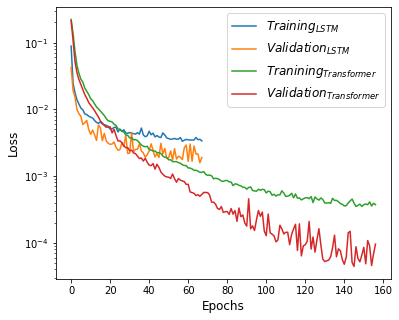

In [ ]:
# Plot loss
plt.figure(figsize=(6,5))
plt.semilogy(result_lstm.history['loss'],label='$Training_{LSTM}$')
plt.semilogy(result_lstm.history['val_loss'],label='$Validation_{LSTM}$')
plt.semilogy(result_trans.history['loss'],label='$Tranining_{Transformer}$')
plt.semilogy(result_trans.history['val_loss'],label='$Validation_{Transformer}$')
plt.legend(loc=1, fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=12)

# plt.savefig(path + 'Loss_surrogate_SISO_FOPDT_multistep.eps', format='eps')

## 5. Using measured values to predict next step

### LSTM

In [ ]:
# # Load NN Models
# model_lstm = load_model(path + 'MPC_surrogate_SISO_FOPDT_LSTM.h5')
# model_trans = load_model(path + 'MPC_surrogate_SISO_FOPDT_Transformer.h5')

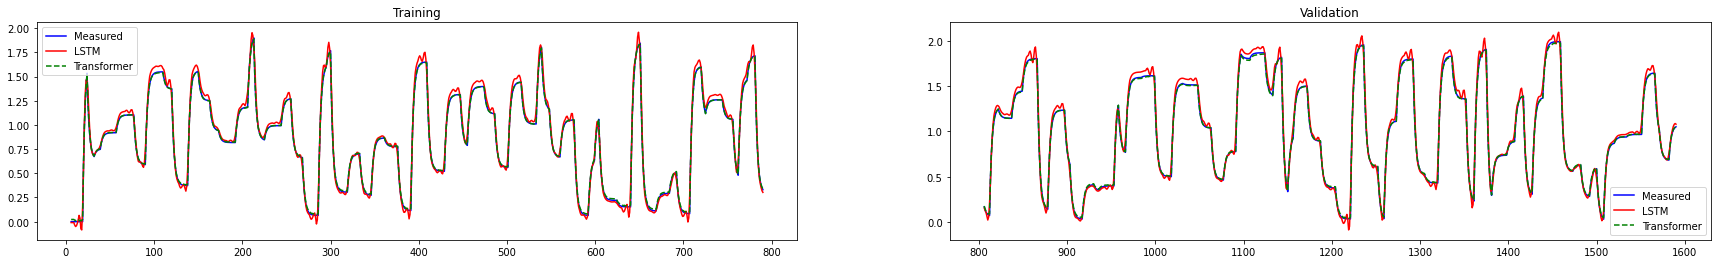

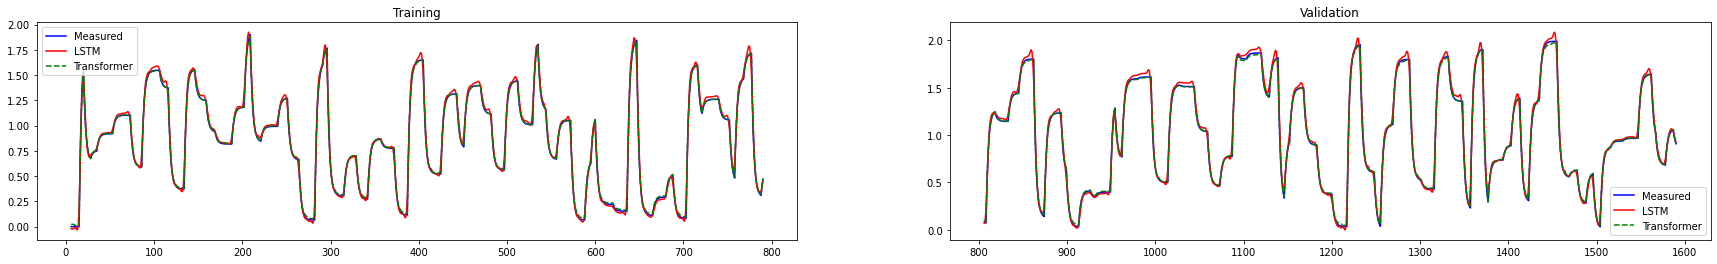

In [ ]:
# Verify the fit of the model
Yp_train_lstm = model_lstm.predict(X_train)
Yp_val_lstm = model_lstm.predict(X_val)

# un-scale outputs
Yu_train_lstm = s2.inverse_transform(Yp_train_lstm) # model prediction
Ym_train = s2.inverse_transform(Y_train) # measured value

Yu_val_lstm = s2.inverse_transform(Yp_val_lstm) # model prediction
Ym_val = s2.inverse_transform(Y_val) # measured value


# Verify the fit of the model
Yp_train_trans = model_trans.predict(X_train)
Yp_val_trans = model_trans.predict(X_val)

# un-scale outputs
Yu_train_trans = s2.inverse_transform(Yp_train_trans) # model prediction
Ym_train = s2.inverse_transform(Y_train) # measured value

Yu_val_trans = s2.inverse_transform(Yp_val_trans) # model prediction
Ym_val = s2.inverse_transform(Y_val) # measured value




plt.figure(0, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b-',label='Measured')
plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,0],'g--',label='Transformer')

plt.title('Training')
plt.legend()
plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Ym_val[:,0],'b-',label='Measured')
plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,0],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,0],'g--',label='Transformer')
plt.title('Validation')
plt.legend()

plt.figure(1, figsize=(30,4))
plt.subplot(1,2,1)
plt.plot(data.index[window:cut_index-P],Ym_train[:,4],'b-',label='Measured')
plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,4],'r-',label='LSTM')
plt.plot(data.index[window:cut_index-P],Yu_train_trans[:,4],'g--',label='Transformer')
plt.title('Training')
plt.legend()

plt.subplot(1,2,2)
plt.plot(data.index[cut_index+window:-P],Ym_val[:,4],'b-',label='Measured')
plt.plot(data.index[cut_index+window:-P],Yu_val_lstm[:,4],'r-',label='LSTM')
plt.plot(data.index[cut_index+window:-P],Yu_val_trans[:,4],'g--',label='Transformer')
plt.title('Validation')
plt.legend()



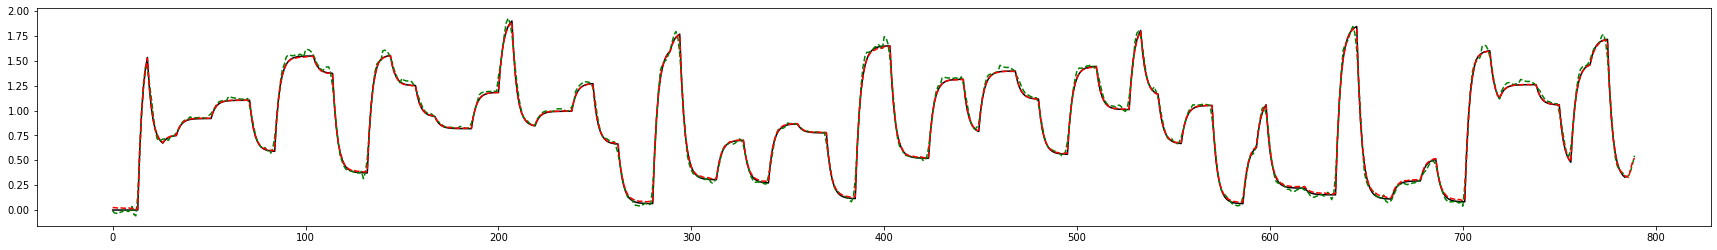

In [ ]:
# plt.plot(data.index[window:cut_index-P],Ym_train[:,0],'b-',label='Measured')
# plt.plot(data.index[window:cut_index-P],Yu_train_lstm[:,0],'r-',label='LSTM')
plt.figure(figsize=(30,4))
plt.plot(Ym_train[:,0], 'k-')
plt.plot(Y2, 'g--')
plt.plot(Y1,'r--',label='Transformer')



np.shape(Yu_train_trans[0:785:10])
Y1 = np.transpose(np.reshape(Yu_train_trans[0:785:10], (1,790)))
Y2 = np.transpose(np.reshape(Yu_train_lstm[0:785:10], (1,790)))
np.reshape()

No handles with labels found to put in legend.


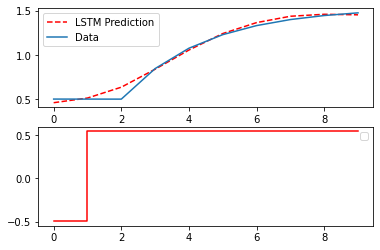

In [ ]:
j =210
plt.subplot(2,1,1)
plt.plot(Yu_val_lstm[j], 'r--', label='LSTM Prediction')
plt.plot(Ym_val[j], label='Data')
plt.legend()

plt.subplot(2,1,2)
plt.plot(X_val[j][window:,0], 'r-', drawstyle = 'steps')
plt.legend()